In [1]:
import numpy as np
import cv2
import requests
import pandas as pd
import glob
import requests
import urllib.request
import os

from io import BytesIO
from IPython.display import Image, display
from clip_retrieval.clip_client import ClipClient, Modality
from matplotlib import pyplot as plt
from deepface import DeepFace
from PIL import Image as PImg

In [2]:
# Fucntion which converts sentences to camel case and removes spaces used for folder names
def camel_case(text):
    # Split the text into words by space
    words = text.split()

    # Capitalize the first letter of each word (except the first word)
    camel_case_words = (word.capitalize() for word in words)

    # Join the words together to form the CamelCase string
    camel_case_text = ''.join(camel_case_words)

    return camel_case_text

In [3]:
# Function used to retrive image links from the LAION-5B dataset 
def retrieveImages(text, aes_score, aes_weight, num_of_images):
    client = ClipClient(
        url="https://knn.laion.ai/knn-service",
        indice_name="laion5B-H-14",
        aesthetic_score=aes_score,
        aesthetic_weight=aes_weight,
        modality=Modality.IMAGE,
        num_images=num_of_images,
    )
    
    img_result = client.query(text)
    return img_result

In [4]:
# Function which given a list of image links attempts to return all links as their appropraite images
def RetrieveImagesFromLinks(listOfImageLinks):
    images = []
    
    tmpCounter = 0 #------
    
    for img_url in listOfImageLinks:
        tmpCounter+=1 #---------
        print(tmpCounter) #---------

        try:
            image_data = urllib.request.urlopen(img_url['url'], timeout=10)

            img = plt.imread(image_data, format='jpg')

            images.append(img)
        except Exception as error:
            print(str(error))
    
    return images

In [5]:
# Function which retrieves the requsted amount of images according to the parameters passed
def RetrieveImagesLAION(text, aes_score, aes_weight, num_of_images, save_images):
    images = []
    
    noImages = num_of_images*2 #done for testing purposes to see if better running time
    
    while len(images) < num_of_images:
        # Retrieving the image urls from LAION-5B dataset
        image_links = retrieveImages(text, aes_score, aes_weight, noImages)
        print("NoImagesLinks: ",len(image_links))
        
        # Retrieving the images from their respective urls
        images = RetrieveImagesFromLinks(image_links)
        print("NoImagesRetrieved: ",len(images))
        
        # Doubling the number of images required in case some images were failed to be retrieved
        noImages = noImages*2
    
    # Removing any extra images 
    images = images[:num_of_images]
    
    if save_images:
        # Check if the folder exists, and if not, create it
        folder_path = Path("DownloadedImages")
        if not folder_path.exists():
            folder_path.mkdir()
    
        # Check if the folder exists, and if not, create it
        sub_folder_path = Path(os.path.join("DownloadedImages",camel_case(text)))
        if not sub_folder_path.exists():
            sub_folder_path.mkdir()
        
        for imgIndex in range(len(images)):
            save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
            cv2.imwrite(save_path, cv2.cvtColor(images[imgIndex], cv2.COLOR_BGR2RGB))
    return images

In [6]:
#Function which can save the DeepFaceDict as csv from the DeepFaceProcess function
def save_metrics_CSV(sub_folder_path, metric_dict):
    # Specify the CSV file path
    csv_file_path = Path(os.path.join(sub_folder_path, 'output_data.csv'))

    # Open the CSV file for writing
    with open(csv_file_path, mode='w', newline='') as file:
        fieldnames = ['Image_No','Age', 'Gender', 'Race', 'Emotion']
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        # Write the header row
        writer.writeheader()

        # Write the image properties to the CSV file
        for image_name, properties in metric_dict.items():
            writer.writerow({
                'Image_No': image_name,
                'Age': properties[1]["age"],
                'Gender': properties[1]["gender"],
                'Race': properties[1]["race"],
                'Emotion': properties[1]["emotion"]
            })

In [7]:
# from deepface import DeepFace

# This function is an improved implementation of the previous DeepFaceProcess function, 
# having multi face detection capabilites whilst using the mtcnn detector backend  
def DeepFaceProcess(listOfImages,prompt_used,save_metrics):
    DeepFaceDict = {}
    counter = 0
    
    for imgIndex in range(len(listOfImages)):
        try:
            # Retrieving the age/gender/race/emotion of the image
            # Note: enforce_detection=False used so that images where the face isn't fully visible are still considered
            objs = DeepFace.analyze(listOfImages[imgIndex], actions = ['age', 'gender', 'race', 'emotion'], enforce_detection=False,  detector_backend = "mtcnn")
            
            for index in range(len(objs)):
                if objs[index]['dominant_gender'] == "Man":
                    ImageInfo = {'age':objs[index]['age'], 'gender':"Male", 'race':objs[index]['dominant_race'], 'emotion':objs[index]['dominant_emotion']}
                elif objs[index]['dominant_gender'] == "Woman":
                    ImageInfo = {'age':objs[index]['age'], 'gender':"Female", 'race':objs[index]['dominant_race'], 'emotion':objs[index]['dominant_emotion']}
                
                # Cropping the image to only include the face
                objs[index]['region']
                x = objs[index]['region']['x']
                y = objs[index]['region']['y']
                width = objs[index]['region']['x'] + objs[index]['region']['w']
                height = objs[index]['region']['y'] + objs[index]['region']['h']
                croppedImg = listOfImages[imgIndex][y:height, x:width]
                
                # Storing the images in a dictionary 
                DeepFaceDict[counter] = [croppedImg,ImageInfo]
                counter+=1
        except Exception as error:
            counter-=1
            print(error)
    
    
    # Check if the folder exists, and if not, create it
    sub_folder_path = Path(os.path.join("DownloadedImages",camel_case(prompt_used)))
    if not sub_folder_path.exists():
        sub_folder_path.mkdir()
    
    save_metrics_CSV(sub_folder_path, DeepFaceDict)
    return DeepFaceDict

In [8]:
Images = RetrieveImagesLAION(text="Real Human Doctor", aes_score=9, aes_weight=0.5, num_of_images=200, save_images=True)
Result = DeepFaceProcess(listOfImages=Images, prompt_used="Real Human Doctor",save_metrics=True)

NoImages:  600
RetriveImages: 479
NoImagesLinks:  479
1
2
3
4
HTTP Error 403: Forbidden
5
6
7
8
9
10
11
12
13
HTTP Error 404: Not Found
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
HTTP Error 404: Not Found
36
37
38
39
40
41
42
43
44
45
46
47
48
HTTP Error 403: Forbidden
49
50
51
52
53
54
<urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>
55
56
57
58
59
60
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)>
61
62
63
HTTP Error 403: Forbidden
64
65
HTTP Error 403: Forbidden
66
67
68
69
70
71
72
HTTP Error 403: Forbidden
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
HTTP Error 404: Not Found
90
91
92
93
HTTP Error 403: Forbidden
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
<urlopen error [Errno 2] No such file or directory>
112
113
114
115
116
117
118
HTTP Error 404: Not Found
119
120
121
<urlopen error [SSL: CERTIFICATE_V

NameError: name 'Path' is not defined

In [ ]:
# image_links = retrieveImages(text="Real Human Doctor", aes_score=9, aes_weight=0.5, num_of_images=600)

In [ ]:
# image_data = urllib.request.urlopen(image_links[208]['url'], timeout=10)

# img = plt.imread(image_data, format='jpg')

# plt.imshow(img)

#### YOLO Person Detection

In [20]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf
import torch
import math

Ultralytics YOLOv8.0.20  Python-3.9.18 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


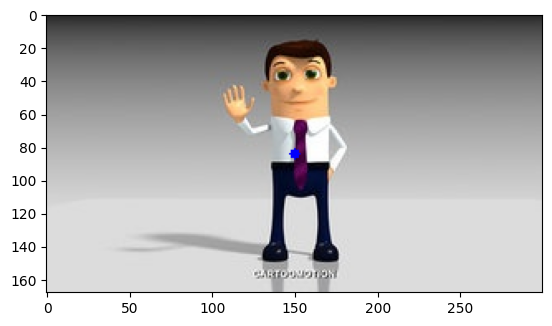

IndexError: list index out of range

In [34]:
# Load YOLOv3 model
model = YOLO('yolov8n.pt')

classes = [0]

image_path = 'DownloadedImages\\CartoonHuman\\10.jpg'

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = image

# Make predictions
predictions = model.predict(input_image, classes=0)

# Extract relevant information from the predictions
boxes = predictions[0].boxes.xyxy  # Assuming Ultralytics Boxes object has a property xyxy
scores = predictions[0].boxes.conf
classes = predictions[0].boxes.cls

# Postprocess predictions
confidence_threshold = 0.8

# Filter out predictions below the confidence threshold
filtered_indices = torch.where(scores > confidence_threshold)[0]
filtered_boxes = boxes[filtered_indices]
filtered_classes = classes[filtered_indices]

# Draw bounding boxes
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Finding the area of the image
area_of_image = image.shape[0] * image.shape[1]
image_center_x = image.shape[1] // 2
image_center_y = image.shape[0] // 2
cv2.circle(image, (image_center_x, image_center_y), 3, (0, 0, 255), -1)

cropped_images = []
for box, class_id in zip(filtered_boxes, filtered_classes):
    box = box.cpu().numpy().astype(int)
    class_id = int(class_id.cpu().numpy())

    # Crop the region of interest (ROI) based on the bounding box
    cropped_image = image[box[1]:box[3], box[0]:box[2]]
    cropped_images.append(cropped_image)

    area_of_cropped_image = cropped_image.shape[0] * cropped_image.shape[1]

    # Add a dot at the center
    center_x = (box[0] + box[2]) // 2
    center_y = (box[1] + box[3]) // 2
    cv2.circle(image, (center_x, center_y), 3, (255, 0, 0), -1)

    distance_between_centers = math.dist([center_x, center_y], [image_center_x, image_center_y])
    print("Distance :", distance_between_centers)
    print("Area Cropped :", area_of_cropped_image, "Area Image :", area_of_image)
    print("Area Taken :", area_of_cropped_image / area_of_image * 100, "%")

    label = f"Class {class_id}"
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    cv2.putText(image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the result
plt.imshow(image)
plt.show()
plt.imshow(cropped_images[0])
plt.show()
plt.imshow(cropped_images[1])
plt.show()
plt.imshow(cropped_images[2])
plt.show()


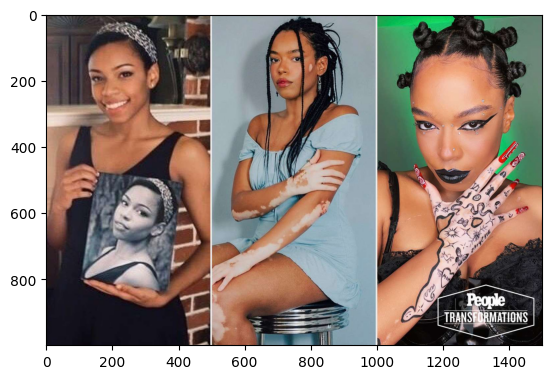

In [5]:
# Draw bounding boxes
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)